In [67]:
## 导入所需库
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import kmodes

# 忽略警告
import warnings
warnings.filterwarnings("ignore")  # 忽略所有警告信息

# 设置中文字体
matplotlib.rcParams['font.family'] = 'SimHei'  # 黑体
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['axes.unicode_minus'] = False  # 正确显示负号

### 数据提取

In [68]:
## 读取数据
data1 = pd.read_csv("../处理后的数据/表1-患者列表及临床信息.csv")
data2 = pd.read_csv("../处理后的数据/表2-血肿及水肿的体积及位置.csv")
data2 = data2[data2["检查次序"] == 0]  # 只保留第一次检查的数据
data2.drop(columns=["流水号"], inplace=True)

# ED代表水肿，HM代表血肿
data3_ED = pd.read_csv("../处理后的数据/表3_水肿的形状及灰度分布_ED.csv")
data3_HM = pd.read_csv("../处理后的数据/表3_血肿的形状及灰度分布_HM.csv")

# data_time_number = pd.read_csv("../处理后的数据/附表1-时间点-流水号.csv")

In [95]:
## 数据合并
df = pd.merge(data1, data2, on="ID", how="left")
df = pd.merge(df, data3_ED, on="流水号", how="left")
df = pd.merge(df, data3_HM, on="流水号", how="left")
df.reset_index(drop=True, inplace=True)
df.drop(columns=["数据集划分", "流水号"], inplace=True)
print('df的shape:', df.shape)
df.head(1)

df的shape: (160, 107)


,ID,90天mRS,年龄,性别,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,...,ED_NCCT_original_firstorder_MeanAbsoluteDeviation_y,ED_NCCT_original_firstorder_Mean_y,ED_NCCT_original_firstorder_Median_y,ED_NCCT_original_firstorder_Minimum_y,ED_NCCT_original_firstorder_Range_y,ED_NCCT_original_firstorder_RobustMeanAbsoluteDeviation_y,ED_NCCT_original_firstorder_RootMeanSquared_y,ED_NCCT_original_firstorder_Skewness_y,ED_NCCT_original_firstorder_Uniformity_y,ED_NCCT_original_firstorder_Variance_y
0,sub001,4.0,43,女,0,0,0,0,0,0,...,29.700551,172.025325,180.997857,86.200064,161.239687,22.759625,175.551025,-0.523096,0.089596,1225.449943


In [96]:
df.dtypes

ID                                                            object
90天mRS                                                       float64
年龄                                                             int64
性别                                                            object
脑出血前mRS评分                                                      int64
                                                              ...   
ED_NCCT_original_firstorder_RobustMeanAbsoluteDeviation_y    float64
ED_NCCT_original_firstorder_RootMeanSquared_y                float64
ED_NCCT_original_firstorder_Skewness_y                       float64
ED_NCCT_original_firstorder_Uniformity_y                     float64
ED_NCCT_original_firstorder_Variance_y                       float64
Length: 107, dtype: object

In [97]:
## 将性别转换为 0/1 变量
df["性别"] = df["性别"].map({"男": 1, "女": 0})
df["年龄"] = df["年龄"].astype(int)

In [98]:
## 将血压切分为收缩压和舒张压
df["收缩压"] = df["血压"].str.split("/").str[0].astype(int)
df["舒张压"] = df["血压"].str.split("/").str[1].astype(int)
df.drop(columns=["血压"], inplace=True)

In [99]:
df

,ID,90天mRS,年龄,性别,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,...,ED_NCCT_original_firstorder_Median_y,ED_NCCT_original_firstorder_Minimum_y,ED_NCCT_original_firstorder_Range_y,ED_NCCT_original_firstorder_RobustMeanAbsoluteDeviation_y,ED_NCCT_original_firstorder_RootMeanSquared_y,ED_NCCT_original_firstorder_Skewness_y,ED_NCCT_original_firstorder_Uniformity_y,ED_NCCT_original_firstorder_Variance_y,收缩压,舒张压
0,sub001,4.0,43,0,0,0,0,0,0,0,...,180.997857,86.200064,161.239687,22.759625,175.551025,-0.523096,0.089596,1225.449943,180,90
1,sub002,0.0,58,1,0,1,0,0,0,0,...,137.569328,69.446385,152.848311,26.758880,145.014063,0.113439,0.074774,1394.452289,199,120
2,sub003,5.0,78,1,0,1,0,0,0,0,...,133.217856,61.683739,164.933560,19.037080,135.747065,0.019111,0.098694,812.571273,199,120
3,sub004,4.0,70,1,2,1,1,0,0,0,...,124.293778,59.981668,230.164456,21.618937,130.690592,0.323449,0.123988,1061.812328,186,99
4,sub005,3.0,51,1,0,0,0,0,0,0,...,146.017474,81.014412,134.699827,20.821637,148.459109,0.027286,0.075332,941.159277,135,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,sub156,NaN,87,0,0,1,0,0,0,1,...,164.066390,70.673443,172.634691,23.249281,160.506826,-0.361789,0.093402,1197.455955,202,100
156,sub157,NaN,52,1,2,1,1,0,0,0,...,130.646541,80.895735,137.877988,23.801815,142.564984,0.370272,0.079659,1136.715001,180,110
157,sub158,NaN,57,1,0,1,0,0,0,0,...,140.340882,72.739560,145.190811,21.965813,145.662234,0.121713,0.080621,1002.436615,233,135
158,sub159,NaN,47,1,0,1,0,0,0,0,...,127.096626,60.051468,147.538845,20.438976,129.831410,0.021460,0.088573,856.411554,183,122


<Axes: xlabel='90天mRS'>

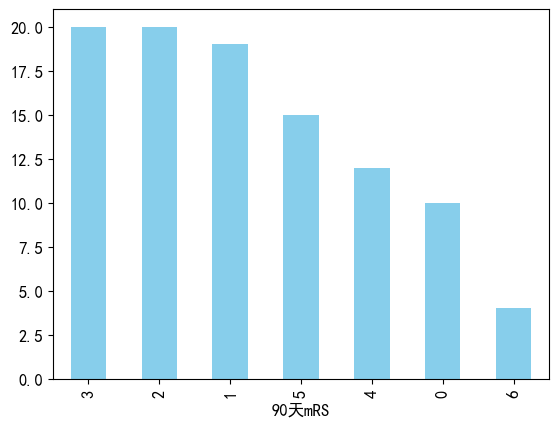

In [100]:
## 90天MRS绘图
df[df["ID"] <= 'sub100']["90天mRS"].astype(int).value_counts().plot(kind="bar", color="skyblue")

In [104]:
# 筛选出含有缺失值的行
df[df.isnull().T.any()].shape

(60, 108)

In [120]:
df.shape

(160, 108)

In [121]:
df.to_csv("../处理后的数据/q3a建模前数据-未归一化.csv", index=False)

In [123]:
df.describe(include="all")

,ID,90天mRS,年龄,性别,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,...,ED_NCCT_original_firstorder_Median_y,ED_NCCT_original_firstorder_Minimum_y,ED_NCCT_original_firstorder_Range_y,ED_NCCT_original_firstorder_RobustMeanAbsoluteDeviation_y,ED_NCCT_original_firstorder_RootMeanSquared_y,ED_NCCT_original_firstorder_Skewness_y,ED_NCCT_original_firstorder_Uniformity_y,ED_NCCT_original_firstorder_Variance_y,收缩压,舒张压
count,160,100.000000,160.000000,160.000000,160.000000,160.00000,160.000000,160.000000,160.000000,160.000000,...,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
unique,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,sub001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.660000,64.100000,0.687500,0.137500,0.88125,0.225000,0.150000,0.043750,0.087500,...,146.688435,75.238476,161.339559,22.604022,149.640761,0.017237,0.090503,1102.736136,169.656250,94.812500
std,NaN,1.689062,13.945176,0.464968,0.495102,0.32451,0.418893,0.358193,0.205181,0.283454,...,20.069771,11.304787,31.578330,4.354465,18.115035,0.276175,0.017202,322.486804,26.086466,16.930189
min,NaN,0.000000,30.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,109.399064,51.248777,77.692144,10.047896,109.615504,-0.652625,0.069383,284.441811,108.000000,50.000000
25%,NaN,1.000000,53.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,...,131.444901,67.800869,143.187316,19.237201,137.288642,-0.163362,0.080312,867.773464,152.000000,81.750000
50%,NaN,3.000000,64.000000,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,...,146.217016,74.979364,155.447508,22.900115,149.813073,0.005052,0.083839,1114.970679,167.000000,95.000000
75%,NaN,4.000000,76.000000,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,...,158.186841,81.872635,170.154456,25.862507,160.067252,0.162806,0.093742,1337.781789,184.250000,104.250000


## 数据划分

In [125]:
train_data = df[df["ID"] <= 'sub100']
test_data = df[df["ID"] > 'sub100']
test_data = test_data.drop(columns=["ID", "90天mRS"])
X = train_data.drop(columns=["ID", "90天mRS"])
y = train_data["90天mRS"].astype(int)

# 随机切分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [117]:
y

0     4
1     0
2     5
3     4
4     3
     ..
95    4
96    2
97    5
98    3
99    2
Name: 90天mRS, Length: 100, dtype: int32

## lasso + logistic 分类

### 交叉验证

Best regularization parameter C: 0.08858667904100823
Test set accuracy: 0.200


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

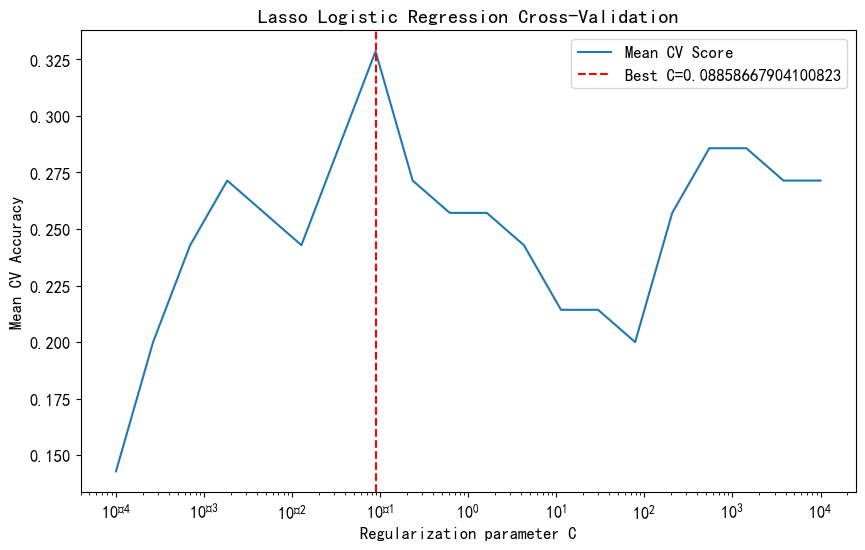

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split

# 创建 Logistic Regression 模型，使用 Lasso 正则化（L1）
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# 定义正则化强度参数的范围（C 是正则化参数的倒数）
param_grid = {'C': np.logspace(-4, 4, 20)}

# 使用 GridSearchCV 进行交叉验证
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最优的正则化参数 C
print(f"Best regularization parameter C: {grid_search.best_params_['C']}")  # [^74^]

# 在测试集上评估模型
test_score = grid_search.score(X_test, y_test)
print(f"Test set accuracy: {test_score:.3f}")  # [^74^]

# 绘制交叉验证结果
plt.figure(figsize=(10, 6))
# 设置 Matplotlib 配置
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
plt.semilogx(param_grid['C'], grid_search.cv_results_['mean_test_score'], label='Mean CV Score')
plt.axvline(grid_search.best_params_['C'], color='r', linestyle='--', label=f'Best C={grid_search.best_params_["C"]}')
plt.xlabel('Regularization parameter C')
plt.ylabel('Mean CV Accuracy')
plt.legend()
plt.title('Lasso Logistic Regression Cross-Validation')
plt.show()

## 不使用cpu加速：8min
## 使用cpu加速：1min

### 数据增强，重新建模预测

In [ ]:
## 切分训练数据和测试数据

## 针对训练数据，切分训练集和测试集


## 交叉验证，选择最优超参数


## 训练模型


## 模型评估

In [ ]:
## 前文使用了lasso + logistic，我们可以考虑再结合随机森林、svm、xgboost、adaboost、catboost等模型进行集成。

## SVM or Kernel SVM

### 交叉验证

### 数据增强，重新建模预测

## 随机森林

### 交叉验证

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# 2. 创建随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 3. 设置交叉验证策略
# 使用分层 K 折交叉验证（StratifiedKFold），确保每折中各类别的比例与整体数据一致
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. 使用交叉验证评估模型性能
# 计算准确率
cv_scores = cross_val_score(rf_model, X, y, cv=cv_strategy, scoring='accuracy')

# 输出交叉验证的准确率
print(f"交叉验证准确率：{cv_scores}")
print(f"平均准确率：{cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 5. 训练模型并输出详细的分类报告（可选）
# 如果需要更详细的性能指标，可以手动进行交叉验证并输出分类报告
from sklearn.model_selection import train_test_split

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 训练模型
rf_model.fit(X_train, y_train)

# 预测测试集
y_pred = rf_model.predict(X_test)

# 输出分类报告
print("\n分类报告：")
print(classification_report(y_test, y_pred))

# 输出混淆矩阵
print("\n混淆矩阵：")
print(confusion_matrix(y_test, y_pred))

交叉验证准确率：[0.35 0.25 0.3  0.3  0.2 ]
平均准确率：0.2800 ± 0.0510

分类报告：
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.17      0.25      0.20         4
           2       0.29      0.50      0.36         4
           3       0.33      0.25      0.29         4
           4       0.50      0.50      0.50         2
           5       0.50      0.33      0.40         3
           6       0.00      0.00      0.00         1

    accuracy                           0.30        20
   macro avg       0.26      0.26      0.25        20
weighted avg       0.28      0.30      0.28        20


混淆矩阵：
[[0 0 1 0 0 1 0]
 [0 1 3 0 0 0 0]
 [0 2 2 0 0 0 0]
 [0 2 0 1 1 0 0]
 [0 0 1 0 1 0 0]
 [0 0 0 2 0 1 0]
 [0 1 0 0 0 0 0]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 3. 定义随机森林模型
rf_model = RandomForestClassifier(random_state=42)

# 4. 定义调参的参数网格
param_grid = {
    'n_estimators': [50, 100, 200],  # 树的数量
    'max_depth': [None, 10, 20, 30],  # 树的最大深度（剪枝参数）
    'min_samples_split': [2, 5, 10],  # 分裂内部节点所需的最小样本数
    'min_samples_leaf': [1, 2, 4],  # 在叶子节点处需要的最小样本数（剪枝参数）
    'max_features': ['sqrt', 'log2', None]  # 在寻找最佳分裂时考虑的特征数量
}

# 5. 设置交叉验证策略
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6. 使用 GridSearchCV 进行调参和交叉验证
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv_strategy, 
                           scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 7. 输出最佳参数和最佳模型的性能
print("最佳参数:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# 8. 在测试集上评估模型
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"测试集准确率: {accuracy:.4f}")
print("分类报告：")
print(classification_report(y_test, y_pred))
print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
最佳参数: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
测试集准确率: 0.4000
分类报告：
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.20      0.25      0.22         4
           2       0.33      0.75      0.46         4
           3       0.67      0.50      0.57         4
           4       1.00      0.50      0.67         2
           5       0.50      0.33      0.40         3
           6       0.00      0.00      0.00         1

    accuracy                           0.40        20
   macro avg       0.39      0.33      0.33        20
weighted avg       0.42      0.40      0.38        20

混淆矩阵：
[[0 0 1 0 0 1 0]
 [0 1 3 0 0 0 0]
 [0 1 3 0 0 0 0]
 [0 1 1 2 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 1 0]
 [0 1 0 0 0 0 0]]


### 数据增强，重新建模预测

## catboost

### 交叉验证

In [128]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# 定义 CatBoost 模型
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# 定义调参的参数网格
param_grid = {
    'iterations': [100, 200],  # 迭代次数
    'learning_rate': [0.01, 0.1],  # 学习率
    'depth': [4, 6, 8],  # 树的最大深度（剪枝参数）
    'l2_leaf_reg': [1, 3, 5],  # L2 正则化参数
    'min_data_in_leaf': [1, 5, 10]  # 叶子节点的最小样本数（剪枝参数）
}

# 设置交叉验证策略
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 使用 GridSearchCV 进行调参和交叉验证
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=cv_strategy, 
                           scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳模型的性能
print("最佳参数:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# 在测试集上评估模型
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"测试集准确率: {accuracy:.4f}")
print("分类报告：")
print(classification_report(y_test, y_pred))
print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

### 数据增强，重新建模预测

## lightgbm

### 交叉验证

In [129]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# 定义 LightGBM 模型
lgbm_model = LGBMClassifier(random_state=42)

# 定义调参的参数网格
param_grid = {
    'n_estimators': [100, 200],  # 树的数量
    'learning_rate': [0.01, 0.1],  # 学习率
    'max_depth': [-1, 4, 6],  # 树的最大深度（-1 表示无限制）
    'num_leaves': [15, 31, 63],  # 叶子节点的数量
    'lambda_l1': [0, 0.1, 0.5],  # L1 正则化参数
    'lambda_l2': [0, 0.1, 0.5]  # L2 正则化参数
}

# 设置交叉验证策略
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 使用 GridSearchCV 进行调参和交叉验证
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=cv_strategy, 
                           scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳模型的性能
print("最佳参数:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# 在测试集上评估模型
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"测试集准确率: {accuracy:.4f}")
print("分类报告：")
print(classification_report(y_test, y_pred))
print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


LightGBMError: Do not support special JSON characters in feature name.

### 数据增强，重新建模预测

## xgboost

### 交叉验证

In [130]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# 定义 XGBoost 模型
xgb_model = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

# 定义调参的参数网格
param_grid = {
    'n_estimators': [100, 200],  # 树的数量
    'learning_rate': [0.01, 0.1],  # 学习率
    'max_depth': [4, 6, 8],  # 树的最大深度
    'subsample': [0.7, 0.9],  # 子采样比例
    'colsample_bytree': [0.7, 0.9],  # 每棵树使用的特征比例
    'gamma': [0, 0.1],  # 惩罚项中叶子结点个数前的参数
    'reg_lambda': [1, 2]  # L2 正则化参数
}

# 设置交叉验证策略
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 使用 GridSearchCV 进行调参和交叉验证
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv_strategy, 
                           scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳模型的性能
print("最佳参数:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# 在测试集上评估模型
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"测试集准确率: {accuracy:.4f}")
print("分类报告：")
print(classification_report(y_test, y_pred))
print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 192 candidates, totalling 960 fits
最佳参数: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 1, 'subsample': 0.7}
测试集准确率: 0.1000
分类报告：
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         4
           2       0.14      0.25      0.18         4
           3       0.00      0.00      0.00         4
           4       1.00      0.50      0.67         2
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         1

    accuracy                           0.10        20
   macro avg       0.16      0.11      0.12        20
weighted avg       0.13      0.10      0.10        20

混淆矩阵：
[[0 0 1 0 0 1 0]
 [0 0 3 1 0 0 0]
 [1 2 1 0 0 0 0]
 [0 2 1 0 0 1 0]
 [0 0 1 0 1 0 0]
 [1 1 0 1 0 0 0]
 [0 1 0 0 0 0 0]]


### 数据增强，重新建模预测

##